# Modeling ERCOT FTR Prices
Given:
* Hourly ERCOT FTR contract values for unspecified nodes from 2019 to October 2021 
* Corresponding hourly zonal load and wind data, as well as line ratings

Task:
* Attempt to find any relationships in the data and interpret the findings 
* Deliver estimated hourly contract values for the month of November 2021


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Load the datasets

In [3]:
df_contract = pd.read_csv('Problem 3/contract_data.csv')
df_line_rating = pd.read_csv('Problem 3/line_ratings.csv')
df_load = pd.read_csv('Problem 3/load.csv')
df_wind = pd.read_csv('Problem 3/wind.csv')

df_contract.head(2)

,date,hour_beginning,contract_value,label
0,4/5/19,0,-0.0350,actual
1,4/5/19,1,0.1325,actual


In [5]:
df_line_rating.head(2)

,date,hour_beginning,VALLEY,BEARKAT,TREADWELL,MCCAMEY,NORTH.TO.HOUSTON,PANHANDLE,label
0,2019-04-05,0,2556.0,NaN,9999,9999,4531,3531,actual
1,2019-04-05,1,2529.0,NaN,9999,9999,4414,3530,actual


In [7]:
df_load.head(2)

,date,hour_beginning,coast,east,farwest,north,northcentral,southcentral,southern,west,all,label
0,2019-04-05,0,9695.17,1210.05,2976.90,763.80,9192.58,5191.90,2597.92,1238.97,32867.29,actual
1,2019-04-05,1,9281.53,1161.04,2977.81,735.19,8682.21,4799.37,2439.54,1184.93,31261.60,actual


In [9]:
df_wind.head(2)

,date,hour_beginning,coastal,lz_north,lz_south_houston,lz_west,north,panhandle,south,south_houston,west,west_north,all
0,4/5/19,0,185.71,366.14,1138.44,7780.36,400.56,3301.54,1011.69,1138.44,4385.44,8146.50,9284.94
1,4/5/19,1,122.50,409.77,1270.77,8150.21,451.02,3252.51,1160.07,1270.77,4844.66,8559.98,9830.75


### Standardize the date formatting, create a datetime_key to merge over 

In [11]:
# Standardize date formats in all datasets to YYYY-MM-DD

# For wind and contract, date format is MM/DD/YY
df_wind['date'] = pd.to_datetime(df_wind['date'], format='%m/%d/%y')
df_contract['date'] = pd.to_datetime(df_contract['date'], format='%m/%d/%y')

# For load and line_rating, date format is YYYY-MM-DD
df_load['date'] = pd.to_datetime(df_load['date'], format='%Y-%m-%d')
df_line_rating['date'] = pd.to_datetime(df_line_rating['date'], format='%Y-%m-%d')

# Create a unique datetime_key by concatenating date and hour_beginning in each dataset
for df in [df_contract, df_line_rating, df_load, df_wind]:
    df['datetime_key'] = df['date'].dt.strftime('%Y-%m-%d') + '_' + df['hour_beginning'].astype(str).str.zfill(2)

# Add suffixes to variable names so it is clear which table the data is coming from when merged (except for datetime_key)
df_wind = df_wind.add_suffix('_wind').rename(columns={'datetime_key_wind': 'datetime_key'})
df_load = df_load.add_suffix('_load').rename(columns={'datetime_key_load': 'datetime_key'})
df_line_rating = df_line_rating.add_suffix('_line').rename(columns={'datetime_key_line': 'datetime_key'})

df_wind.head(2)

,date_wind,hour_beginning_wind,coastal_wind,lz_north_wind,lz_south_houston_wind,lz_west_wind,north_wind,panhandle_wind,south_wind,south_houston_wind,west_wind,west_north_wind,all_wind,datetime_key
0,2019-04-05,0,185.71,366.14,1138.44,7780.36,400.56,3301.54,1011.69,1138.44,4385.44,8146.50,9284.94,2019-04-05_00
1,2019-04-05,1,122.50,409.77,1270.77,8150.21,451.02,3252.51,1160.07,1270.77,4844.66,8559.98,9830.75,2019-04-05_01


In [13]:
df_load.head(2)

,date_load,hour_beginning_load,coast_load,east_load,farwest_load,north_load,northcentral_load,southcentral_load,southern_load,west_load,all_load,label_load,datetime_key
0,2019-04-05,0,9695.17,1210.05,2976.90,763.80,9192.58,5191.90,2597.92,1238.97,32867.29,actual,2019-04-05_00
1,2019-04-05,1,9281.53,1161.04,2977.81,735.19,8682.21,4799.37,2439.54,1184.93,31261.60,actual,2019-04-05_01


In [15]:
# Merge all datasets on the datetime_key
df = df_contract.merge(df_line_rating, on='datetime_key')
df = df.merge(df_load, on='datetime_key')
df = df.merge(df_wind, on='datetime_key')

df.head(2)

,date,hour_beginning,contract_value,label,datetime_key,date_line,hour_beginning_line,VALLEY_line,BEARKAT_line,TREADWELL_line,...,lz_north_wind,lz_south_houston_wind,lz_west_wind,north_wind,panhandle_wind,south_wind,south_houston_wind,west_wind,west_north_wind,all_wind
0,2019-04-05,0,-0.0350,actual,2019-04-05_00,2019-04-05,0,2556.0,NaN,9999,...,366.14,1138.44,7780.36,400.56,3301.54,1011.69,1138.44,4385.44,8146.50,9284.94
1,2019-04-05,1,0.1325,actual,2019-04-05_01,2019-04-05,1,2529.0,NaN,9999,...,409.77,1270.77,8150.21,451.02,3252.51,1160.07,1270.77,4844.66,8559.98,9830.75


In [17]:
# drop redundant columns
df.drop(['date_line', 'hour_beginning_line', 'label_line', 'date_load', 'hour_beginning_load', 'label_load', 'date_wind',
        'hour_beginning_wind'], axis=1, inplace=True)
print(df.columns)

Index(['date', 'hour_beginning', 'contract_value', 'label', 'datetime_key',
       'VALLEY_line', 'BEARKAT_line', 'TREADWELL_line', 'MCCAMEY_line',
       'NORTH.TO.HOUSTON_line', 'PANHANDLE_line', 'coast_load', 'east_load',
       'farwest_load', 'north_load', 'northcentral_load', 'southcentral_load',
       'southern_load', 'west_load', 'all_load', 'coastal_wind',
       'lz_north_wind', 'lz_south_houston_wind', 'lz_west_wind', 'north_wind',
       'panhandle_wind', 'south_wind', 'south_houston_wind', 'west_wind',
       'west_north_wind', 'all_wind'],
      dtype='object')


### Split the merged dataset into actual/forecast values on label column

In [19]:
df_actual = df[df['label'] == 'actual'].copy()
df_forecast = df[df['label'] == 'forecast'].copy()

df_actual.tail(2)

,date,hour_beginning,contract_value,label,datetime_key,VALLEY_line,BEARKAT_line,TREADWELL_line,MCCAMEY_line,NORTH.TO.HOUSTON_line,...,lz_north_wind,lz_south_houston_wind,lz_west_wind,north_wind,panhandle_wind,south_wind,south_houston_wind,west_wind,west_north_wind,all_wind
22576,2021-10-31,22,0.0,actual,2021-10-31_22,NaN,654.0,9999,3253,5711,...,1057.98,3276.88,9396.68,1117.04,1428.03,2421.38,3276.88,7726.55,10454.66,13731.54
22577,2021-10-31,23,0.0,actual,2021-10-31_23,NaN,659.0,9999,3253,5682,...,937.92,3094.16,8898.84,1000.56,1380.01,2411.09,3094.16,7283.71,9836.76,12930.92


In [21]:
df_forecast.head(2)

,date,hour_beginning,contract_value,label,datetime_key,VALLEY_line,BEARKAT_line,TREADWELL_line,MCCAMEY_line,NORTH.TO.HOUSTON_line,...,lz_north_wind,lz_south_houston_wind,lz_west_wind,north_wind,panhandle_wind,south_wind,south_houston_wind,west_wind,west_north_wind,all_wind
22578,2021-11-01,0,NaN,forecast,2021-11-01_00,NaN,661.0,9999,3253,5549,...,786.37,2967.86,7468.45,836.26,1199.56,2324.25,2967.86,6065.57,8254.82,11222.67
22579,2021-11-01,1,NaN,forecast,2021-11-01_01,NaN,664.0,9999,3253,5439,...,764.25,2925.73,6536.17,812.81,963.92,2298.69,2925.73,5354.84,7300.42,10226.15


### Check if there's a problem with NA values

In [23]:
na_counts = df_actual.isna().sum()
print(na_counts)

date                        0
hour_beginning              0
contract_value              0
label                       0
datetime_key                0
VALLEY_line              8661
BEARKAT_line             5496
TREADWELL_line              0
MCCAMEY_line                0
NORTH.TO.HOUSTON_line       0
PANHANDLE_line              0
coast_load                  0
east_load                   0
farwest_load                0
north_load                  0
northcentral_load           0
southcentral_load           0
southern_load               0
west_load                   0
all_load                    0
coastal_wind                0
lz_north_wind               0
lz_south_houston_wind       0
lz_west_wind                0
north_wind                  0
panhandle_wind              0
south_wind                  0
south_houston_wind          0
west_wind                   0
west_north_wind             0
all_wind                    0
dtype: int64


In [25]:
na_counts = df_forecast.isna().sum()
print(na_counts)

date                       0
hour_beginning             0
contract_value           720
label                      0
datetime_key               0
VALLEY_line              720
BEARKAT_line               0
TREADWELL_line             0
MCCAMEY_line               0
NORTH.TO.HOUSTON_line      0
PANHANDLE_line             0
coast_load                 0
east_load                  0
farwest_load               0
north_load                 0
northcentral_load          0
southcentral_load          0
southern_load              0
west_load                  0
all_load                   0
coastal_wind               0
lz_north_wind              0
lz_south_houston_wind      0
lz_west_wind               0
north_wind                 0
panhandle_wind             0
south_wind                 0
south_houston_wind         0
west_wind                  0
west_north_wind            0
all_wind                   0
dtype: int64


With the number of VALLEY_line and BEARKAT_line values that are blank (41% and 24% respectively), it makes the most sense to completely drop those columns. With more time, it would be interesting to see if a supervised learning model like ensembles would deal with it better or if we could improve results by imputing missing values. I also need to drop a few variables that won't be used in the regression.

In [27]:
df_actual.drop(['date', 'hour_beginning', 'label', 'datetime_key', 'VALLEY_line', 'BEARKAT_line'], axis=1, inplace=True)

### Look at variable distributions, use transformations where necessary

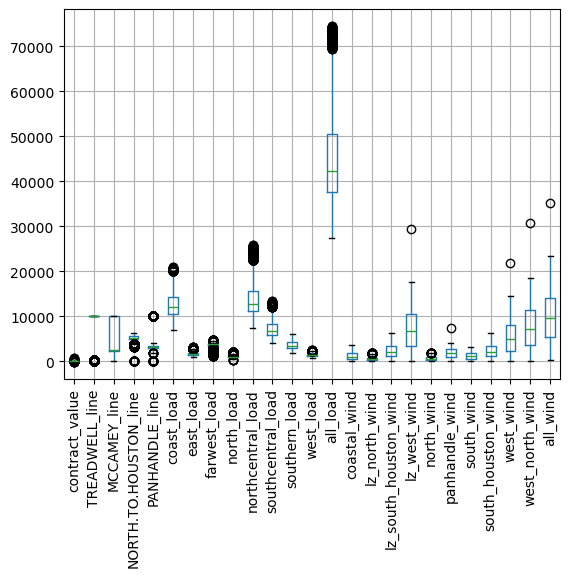

In [29]:
df_actual.boxplot(rot=90)
plt.show()

It actually looks like a fairly normal distribution of variables for the most part. Maybe something going on with right skew outliers in some of the load variables, and the line distributions are non normal (makes sense, line is either at full capacity or significantly lower). With more time, I'd be interested in adding log (or arsinh, if there are zero values) as additional features but for now will continue without any transformations. 

### 80-20 train test split on the actual values

In [31]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_actual, test_size=0.2, random_state=42)
print("training set: " + str(len(train)) + ", test set: " + str(len(test)))

training set: 18062, test set: 4516


### Train the model and evaluate on test set

In [320]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

X_train = train.drop(columns=['contract_value'])
y_train = train['contract_value']
X_test = test.drop(columns=['contract_value'])
y_test = test['contract_value']

# Initialize and fit the model
lasso_model = Lasso(alpha=1.0, warm_start = True, fit_intercept = True, max_iter=50000)
lasso_model.fit(X_train, y_train)

# Predict on the test set
y_hat = lasso_model.predict(X_test)

# Evaluate using R^2
r2 = r2_score(y_test, y_hat)
r2

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.654e+05, tolerance: 6.166e+02
  model = cd_fast.enet_coordinate_descent(


0.27072558757373966

In [322]:
coefficients = pd.Series(lasso_model.coef_, index=X_train.columns)
print(coefficients)

TREADWELL_line           0.000164
MCCAMEY_line            -0.000030
NORTH.TO.HOUSTON_line   -0.001399
PANHANDLE_line          -0.004662
coast_load               0.000000
east_load                0.016840
farwest_load             0.001766
north_load               0.000201
northcentral_load       -0.000300
southcentral_load        0.000078
southern_load            0.004448
west_load               -0.004596
all_load                -0.000769
coastal_wind             0.004175
lz_north_wind            0.000000
lz_south_houston_wind   -0.002021
lz_west_wind             0.001302
north_wind              -0.006791
panhandle_wind           0.001697
south_wind               0.000919
south_houston_wind      -0.001245
west_wind               -0.003112
west_north_wind          0.003243
all_wind                -0.000000
dtype: float64


The Lasso constraint only zeroed-out three of the feature variables. Because a number of these variables are likely not great predictors, I'm going to play around with a higher alpha value to increase regularization.

In [324]:
# Initialize and fit the model
lasso_model = Lasso(alpha=15, warm_start = True, fit_intercept = True, max_iter=20000)
lasso_model.fit(X_train, y_train)

# Predict on the test set
y_hat = lasso_model.predict(X_test)

# Evaluate using R^2
r2 = r2_score(y_test, y_hat)
r2

0.2701533477333956

In [326]:
coefficients = pd.Series(lasso_model.coef_, index=X_train.columns)
print(coefficients)

TREADWELL_line           0.000168
MCCAMEY_line            -0.000024
NORTH.TO.HOUSTON_line   -0.001411
PANHANDLE_line          -0.004665
coast_load              -0.000237
east_load                0.014964
farwest_load             0.001245
north_load               0.000000
northcentral_load       -0.000641
southcentral_load       -0.000000
southern_load            0.003521
west_load               -0.004267
all_load                -0.000413
coastal_wind             0.003195
lz_north_wind           -0.000000
lz_south_houston_wind   -0.001286
lz_west_wind             0.001485
north_wind              -0.003030
panhandle_wind           0.004639
south_wind              -0.000000
south_houston_wind      -0.001035
west_wind               -0.000027
west_north_wind          0.000000
all_wind                -0.000000
dtype: float64


Playing around with alpha removed additional feature variables, but did not improve model performance based on r^2 on the test set. I'd also like to test out a random forests regressor.

In [329]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and fit the model
model = RandomForestRegressor() 
rf = model.fit(X_train, y_train)

# Predict for test set
y_hat = rf.predict(X_test)

# Evaluate using R^2
r2 = r2_score(y_test, y_hat)
r2

0.4919727784506084

Much better model performance on the test set. One tradeoff here is the results are less interpretable. I'll take it though!

### Look at feature importances in the model

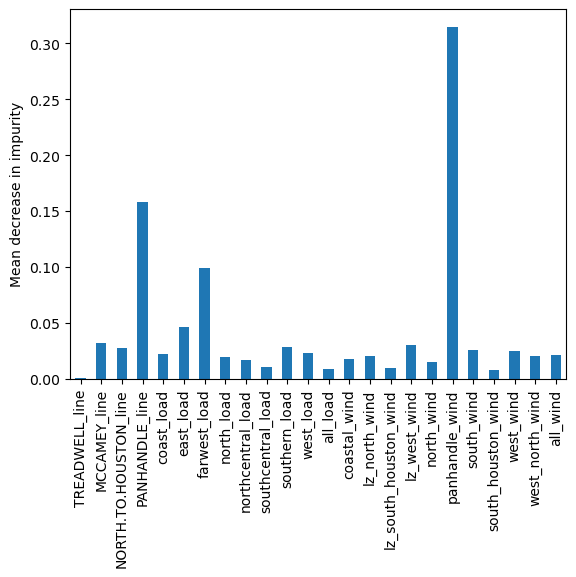

In [376]:
forest_importances = pd.Series(rf.feature_importances_, index=X_train.columns )
ax = forest_importances.plot.bar()
ax.set_ylabel("Mean decrease in impurity")
plt.show()

The panhandle variables showed the strongest correlation here, for both line rating and wind. The Texas Panhandle is a hotspot for wind energy development, so my guess is that this FTR contract is between a node in the panhandle and a load center to the South, perhaps DFW. If the wind is blowing hard in the panhandle, its possible that the panhandle line reaches capacity and results in grid congestion. This means that the locational prices around the constrained line diverge, possibly even flipping negative and incentivizing curtailment from panhandle wind turbines. This is consistent with a strong positive correlation between contract value and panhandle wind, and a negative correlation with the line rating (shown in the Lasso coefficients). 

### Forecast contract values for November

In [339]:
forecast_features = df_forecast.drop(columns=['contract_value', 'date', 'hour_beginning', 'label', 'datetime_key', 'VALLEY_line', 
                                              'BEARKAT_line'])
forecast_contract_values = rf.predict(forecast_features)

In [355]:
df_forecast['contract_value'] = forecast_contract_values
contract_forecast = df_forecast[['date', 'hour_beginning', 'contract_value', 'label']]
contract_forecast.head()

,date,hour_beginning,contract_value,label
22578,2021-11-01,0,17.322175,forecast
22579,2021-11-01,1,18.149800,forecast
22580,2021-11-01,2,24.572450,forecast
22581,2021-11-01,3,33.630325,forecast
22582,2021-11-01,4,30.941275,forecast


In [357]:
contract_forecast.to_csv('contract_forecast_Max_StClair.csv', index = False)